# Case  Study of  Vehicle Routing Problem with Parameter Prediction Model using Sklearn and MiniZinc

## Overview
This case study is adapted from ["Incorporation of parameter prediction models of different fidelity into job shop scheduling"](https://www.sciencedirect.com/science/article/pii/S2405896319301363). In the study, the researchers used a [publicly available dataset](https://www.kaggle.com/c/nyc-taxi-trip-duration) to propose a scheduling problem.

#### Here is the excerpt of the problem:

" We now define a scheduling problem that is based on the dataset but has features that are transferable to industrial job shop scheduling. Let us consider a company, which **head quarter is at Wall Street 2**, located at the South West tip of Manhattan. 

The company performs surveys at remote sites located around NYC. In order to perform a survey, an employee of the company travels to the site by taxi, performs the survey and travels back to the head quarter. We refer to this combination of the outbound taxi trip, the survey and the inbound taxi trip as a task. When performing a survey, an employee relies on a survey team that is based at the head quarter. We consider both taxis and survey teams as processing units, and define the number of both types of units to be two. The number of traveling employees is not restricted. In addition, a taxi that drops off an employee to location A is defined to be instantly available to pick up another employee from location B. 

The objective of the scheduling optimization is to minimize the make span ms of performing surveys at **six different sites located in NYC**. The durations of outbound and inbound taxi trips are predicted , whereas the duration of conducting a survey is fixed to 1800 s. "

#### Steps:
 [1. Import Libraries](#1) <br>
 [2. Get The Data Ready](#2) <br>
 <li style="color:white"> [2.1. Import Data](#21) </li>
 <li style="color:white">   [2.2. Clean and Filter Data](#22) </li>
[3. PREDICT : Choose and Create Prediction Model](#3) <br>
[4. OPTIMIZE : Create MiniZinc Model](#4) <br>
[5. Visualization ](#5) <br>





## 1. Import the Libraries <a class="anchor" id="1"></a>

We will use some common python libraries in this project.

However, for the installation of Altair Library, please follow this [documentation](https://altair-viz.github.io/getting_started/installation.html).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean 
import altair as alt # Library for drawing the Gantt Chart
import folium # Library to draw maps
from math import sin, cos, sqrt, atan2, radians # Library for counting the distance between two points

# Sklearn library
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn import model_selection
from sklearn.model_selection import train_test_split

## 2. Get The Data Ready <a class="anchor" id="2"></a>

### 2.1 Import Data <a class="anchor" id="21"></a>

Get The Kaggle's [NYC Taxi Trip Duration Dataset](https://www.kaggle.com/c/nyc-taxi-trip-duration) as the input parameter for the predictive model.

In [2]:
df = pd.read_csv("nyc-taxi-trip-duration/train.csv")
display(df.shape)
df.head()

(1458644, 11)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### 2.2 Clean and Filter Data <a class="anchor" id="22"></a>

It is mentioned in the paper on how to clean and filter the dataset, as below:

"In order to extract the most relevant information from the dataset for our purpose, we create a filtered dataset, in which either the **pick-up or drop-off** location lies within **500m** from **Wall Street**. In addition, we filter trips with **unrealistically long durations** (>20 000 s)."

Thus, we need to create a function to get the distance between two locations.

In [3]:
# This function is used to get the distance between the first and second latitude and longitude positition
def get_distance_between_points(lat1,lon1,lat2,lon2): 
 
    # approximate radius of earth in km
    R = 6378.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

Set the Headquarter(wall street) and all of the survey's locations.

In [4]:
# As the Headquarter
wall_street_location = [40.70729,-74.01095]

# 6 Survey's location + the headquarter location
all_location = [[40.73,-74.05],[40.665,-73.795],[40.77,-73.995],[40.74,-73.99],[40.695,-73.95],[40.767,-73.875],[40.70729,-74.01095]]

# Give the label for the data
all_location_label = ["1","2","3","4","5","6","HQ"]

dict_location = dict(zip(all_location_label, all_location))


calculate the distance to filter the data

In [5]:
# Get the distance from either pickup or dropoff location to the wall street
df['dist_pickup_to_wall_street'] = np.vectorize(get_distance_between_points)(wall_street_location[0],wall_street_location[1],df['pickup_latitude'], df['pickup_longitude'])
df['dist_dropoff_to_wall_street'] = np.vectorize(get_distance_between_points)(wall_street_location[0],wall_street_location[1],df['dropoff_latitude'], df['dropoff_longitude'])

# Filtered based on the location and the trip durations
df_pickup = df[( df['dist_pickup_to_wall_street'] <= 0.5)& (df['trip_duration'] < 20000)]
df_dropoff = df[( df['dist_dropoff_to_wall_street'] <= 0.5)& (df['trip_duration'] < 20000)]

# Rename the columns name for the concatenation purpose
df_pickup.rename(columns={
    'dropoff_latitude' : 'destination_latitude',
    'dropoff_longitude' : 'destination_longitude',
    'pickup_latitude' : 'origin_latitude',
    'pickup_longitude' : 'origin_longitude'
}, inplace= True)

df_dropoff.rename(columns={
    'dropoff_latitude' : 'origin_latitude',
    'dropoff_longitude' : 'origin_longitude',
    'pickup_latitude' : 'destination_latitude',
    'pickup_longitude' : 'destination_longitude'
}, inplace= True)

# concate those two dataframe
tempp = pd.concat([df_dropoff, df_pickup])

# Calculate distance between origin and destination locations
tempp['dist_pickup_to_dropoff'] = np.vectorize(get_distance_between_points)(tempp['origin_latitude'],tempp['origin_longitude'],tempp['destination_latitude'], tempp['destination_longitude'])
tempp.head()

/Users/lilianaester/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/Users/lilianaester/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,destination_latitude,destination_longitude,dist_dropoff_to_wall_street,dist_pickup_to_wall_street,dropoff_datetime,id,origin_latitude,origin_longitude,passenger_count,pickup_datetime,store_and_fwd_flag,trip_duration,vendor_id,dist_pickup_to_dropoff
3,40.719971,-74.010040,0.128136,1.413665,2016-04-06 19:39:40,id3504673,40.706718,-74.012268,1,2016-04-06 19:32:31,N,429,2,1.487131
79,40.758850,-73.980316,0.255134,6.294377,2016-04-12 21:49:06,id0982165,40.705082,-74.010139,1,2016-04-12 21:29:16,N,1190,2,6.492507
111,40.769772,-73.863678,0.412659,14.236269,2016-05-22 18:20:01,id0589360,40.704895,-74.007217,1,2016-05-22 17:34:08,N,2753,1,14.097312
275,40.717850,-74.000122,0.405326,1.488783,2016-01-06 15:38:22,id0860600,40.709675,-74.014580,1,2016-01-06 15:23:44,N,878,1,1.521914
306,40.726902,-73.985840,0.455422,3.042130,2016-06-26 11:30:33,id0105984,40.704067,-74.014275,1,2016-06-26 11:17:25,N,788,1,3.495305


## 3 PREDICT: Choose and Create Prediction Model <a class="anchor" id="3"></a>

In order to create the model, we will simply try 5 different algorithms from sklearn library, and evaluate its performance. 

Those algorithms are :
<li>Linear Regression</li>
<li>Decision Tree Regressor</li>
<li>Big Random Forest Regressor</li>
<li>Random Forest Regressor</li>
<li>BaggingRegressor</li>

<br>

**Input Parameters:**
- Destination Latitude
- Destination Longitude
- Distance pickup to dropodd
- Trip Duration

**Target Parameter :** Trip Duration

In [6]:
 
temp_df = tempp[['destination_latitude','destination_longitude','dist_pickup_to_dropoff','trip_duration']].copy()

# Declare the model

experiments = {"Algorithm":["Ordinary Least Squares", "Regression Tree", 
                            "Big Random Forest", "Random Forest", 
                            "Bagging"], 
               "Objects" : [lambda : LinearRegression(), 
                            lambda : DecisionTreeRegressor(), 
                            lambda : RandomForestRegressor(n_estimators=100), 
                            lambda : RandomForestRegressor(n_estimators=10), 
                            lambda : BaggingRegressor()], 
               "Predictions":[[] for _ in range(5)]}
actuals = []

In [7]:
# This cell needs sometimes to finish for it will runs 5 different models and evaluate the result

for _ in range (4):
    train_X, test_X, train_y, test_y = (
        train_test_split(temp_df.drop("trip_duration", axis=1), 
                         temp_df["trip_duration"], test_size=0.33))
    for i, obj_factory in enumerate(experiments["Objects"]):
        obj = obj_factory()
        obj.fit(y=train_y,X=train_X)
        experiments["Predictions"][i] += list(obj.predict(test_X))
    actuals += list(test_y)
actuals = pd.Series(actuals)
experiments["Predictions"] = list(map(pd.Series, experiments["Predictions"]))

# Get the performance of every model
experiments["Results"] = []
for o in experiments["Objects"]:
    experiments["Results"].append(
        model_selection.cross_val_score(o(), y=temp_df['trip_duration'], 
                                        X=temp_df.drop("trip_duration", axis=1),
                                        cv=5).mean())

pd.DataFrame(experiments).drop(["Objects", "Predictions"], 
                            axis=1).set_index("Algorithm")

,Results
Algorithm,
Ordinary Least Squares,0.568671
Regression Tree,0.233700
Big Random Forest,0.582372
Random Forest,0.555594
Bagging,0.553416


Big random forest performance very well compare to the other. So, in this case, we will use big random forest as the algorithm to predict the trip duration. To easily re-produce the model, it is important to create the model in a function.

In [30]:
def create_model(df, origin_location,sites_dictionary):
    '''
    parameters : 
        - df = the training dataframe
        - origin_location = the origin location
        - sites_dictionary = all location sites + HQ location
        
    output:
    a list of float that tell the time needed to go to every sites from a given origin location.
    '''
    train_X, test_X, train_y, test_y = ( train_test_split(df.drop("trip_duration", axis=1), 
                             df["trip_duration"], test_size=0.33))

    obj = RandomForestRegressor(n_estimators=100)
    obj.fit(y=train_y,X=train_X)

    ## CREATE THE SAMPLE FOR THE MODEL
    sample_lat = []
    sample_lng = []
    sample_distance = []

    for k,v in sites_dictionary.items():
        sample_lat.append(v[0])
        sample_lng.append(v[1])
        sample_distance.append(get_distance_between_points(origin_location[0],origin_location[1],v[0],v[1]))
        
    
    d = {
    'destination_latitude' : sample_lat,
    'destination_longitude' : sample_lng,
    'dist_pickup_to_dropoff': sample_distance
    }
    
    temp_pred_df = pd.DataFrame(d)  
    
    temp_pred_df['predicted_duration'] = obj.predict(temp_pred_df)
    return temp_pred_df

In [31]:
# Get the predicted time duration matrix
prediction_list = []
for i in dict_location:
    tdf = create_model(temp_df,dict_location[str(i)], dict_location)
    prediction_list.append(list(tdf['predicted_duration'].apply(lambda x : int(x))))
    print(list(tdf['predicted_duration'].apply(lambda x : int(x))))

[715, 3378, 1407, 1399, 2076, 2449, 812]
[2381, 1432, 3064, 2277, 1993, 2173, 2184]
[3052, 3078, 1659, 947, 2078, 1993, 1392]
[2686, 2945, 1051, 1753, 1177, 2397, 895]
[1291, 3857, 2053, 1275, 1502, 2253, 1195]
[2222, 3179, 1874, 1622, 2184, 1246, 1920]
[968, 2781, 1617, 1312, 1245, 1725, 540]


In [32]:
# For every data in the diagonal(time duration from the same place) need to be set to 0.

for i in range(len(prediction_list)):
    prediction_list[i][i] = 0
prediction_list


[[0, 3378, 1407, 1399, 2076, 2449, 812],
 [2381, 0, 3064, 2277, 1993, 2173, 2184],
 [3052, 3078, 0, 947, 2078, 1993, 1392],
 [2686, 2945, 1051, 0, 1177, 2397, 895],
 [1291, 3857, 2053, 1275, 0, 2253, 1195],
 [2222, 3179, 1874, 1622, 2184, 0, 1920],
 [968, 2781, 1617, 1312, 1245, 1725, 0]]

## 4. OPTIMIZE: Create MiniZinc Model <a class="anchor" id="4"></a>

iMiniZinc Installation guide : https://github.com/MiniZinc/iminizinc

In [33]:
%load_ext iminizinc

The iminizinc extension is already loaded. To reload it, use:
  %reload_ext iminizinc


In [34]:
# Data for Minizinc
dist = prediction_list # The distance matrix
NumLocs= 7; # Number of sites + 1 (headquarter)
surveyTime = 1800

In [35]:
%%mzn_model taxi_model
%
% Vehicle Routing Problem
%

% Location data

% Locations
int: NumLocs;
set of int: Locations = 1..NumLocs;

array [Locations, Locations] of int: dist;


% Survey
int: N = NumLocs - 1;

% Vehicles
int: NumRoutes = 4*N; % Worst Case 
set of int: Vehicles = 1..NumRoutes;  % One Vehicle for each Route

% Survey Time
% We assume that the amount of time it takes to do a survey is constant, e.g. 70000 seconds
int: surveyTime;


% =====================================
% Model
% =====================================

include "globals.mzn";

% Define sets of nodes

% Survey locations have 2 states, a start and an end state
set of int: ArriveSurvey = 1..N;
set of int: LeaveSurvey = N+1..2*N;
% 1..2*N represent survey nodes, anything greater is a Depot Node  
% At the worst case, A taxi will visit all survey nodes
set of int: TaxiStart1 = 2*N+1..4*N;  % All Starting Nodes for Taxi 1
set of int: TaxiStart2  = 4*N+1..6*N; % All Starting Nodes for Taxi 2
set of int: Taxi = 1..4*N; % All Taxis
set of int: TaxiEnd1 = 6*N+1..8*N; % All Ending Nodes for Taxi 1
set of int: TaxiEnd2 = 8*N+1..10*N; % All Ending Nodes for Taxi 2

% All Nodes
set of int: Visits = 1..max(TaxiEnd2);
% All Survey Nodes plus Taxi Starting Nodes
set of int: SurveyPlusStarts = 1..max(TaxiStart2);


% Array of Distances between 2 points i and j
% Extended array of distances, including the depot start/end nodes.
array[Visits,Visits] of int: visit_dist = array2d(Visits,Visits,
  [if i> 2 * N /\ j > 2 * N then 0  % Distance between Depots
   elseif i > 2 * N then dist[NumLocs,(j mod N) + 1] % Distance between Depots and Survey (i > Survey)
   elseif j> 2 * N then dist[(i mod N)+1,NumLocs] % Distance between Survey and Depot (j > Survey)
   elseif i + N = j then 0
   elseif j + N = i then 0               % Distance between the same depots is 0
   else dist[(i mod N)+1 ,(j mod N)+1] endif | i,j in Visits]); % Euclidean Distance for the rest

% =====================================
% Decision variables
% =====================================

% Successor representation
array[Visits] of var Visits: successor;

% Time (i-th element is the time when the taxi visits the i-th node)
array[Visits] of var 0..infinity: time;
% Time (i-th element is the time when the i-th survey starts)
array[ArriveSurvey] of var 0..infinity: surveyStart;

% Mapping from visits to route (vehicle) number
array[Visits] of var Vehicles: routeOf;

% Objective function:
% Maximum time taken to complete all surveys
var int: objective = max(time);

% =====================================
% Problem Constraints
% =====================================

% Route & Successor Constraints
% =====================================

% Assign each vehicle depot start node to its route
constraint forall (k in Taxi) ( routeOf[2*N + k] = k);

% Assign each vehicle depot end node to its route
constraint forall (k in Taxi) ( routeOf[6*N + k] = k);

% The successors form a circuit (grand tour representation)
constraint circuit (successor) ::domain;

% successor of an ending taxi node is the next starting taxi node, wraps around to first depot node
constraint
  forall (k in Taxi)
    ( successor[6*N + k] = ( 2*N + 1 + (k mod NumRoutes) ) );

% Successor of starting survey node can only be a depot node or an ending survey node
constraint forall(k in ArriveSurvey)(successor[k] > N);
% Sucessor of ending survey node can only be a depot node or a starting survey node
constraint forall(k in LeaveSurvey)(successor[k] <= N \/ successor[k] >= 2*N + 1);
    
% Link up the routeOf and successor variables:
% Each visit is on the same route as its successor.
% This is true for all survey and start visits, but not for the end visits.
constraint forall (i in SurveyPlusStarts) ( routeOf[i] = routeOf[successor[i]] );


% =====================================
% Survey Constraints
% =====================================

% Survey i should start after or at the time the survey team reaches survey site i
constraint forall(i in ArriveSurvey)(surveyStart[i] >= time[i]);
% The time the taxi leaves from survey site i should be after 1800 seconds from the time the survey starts
constraint forall(i in ArriveSurvey)(surveyStart[i] + surveyTime <= time[i + N]);

% This constraint makes sure that at any given time, only 2 surveys maybe be done in parallel
% It takes in an array of start times, the amount of time it takes to finish the survey, how many survey teams are used for that survey, and the maximum number of survey teams available
constraint cumulative(surveyStart, [surveyTime | i in 1..N], [1 | i in 1..N], 2);

% =====================================
% Time Constraints
% =====================================

% Accumulate Time
constraint forall(i in Visits where i != 4 * N - 1 /\ i != 6 * N - 1)(time[successor[i]] >= time[i] + visit_dist[i, successor[i]]);

% Starting Taxi times are 0, at 2n + 1 and 4n + 1
constraint time[2 * N + 1] = 0;
constraint time[4 * N + 1] = 0;

% Ending Depot Time should be the same as the next Starting Depot Time, for each Taxi
constraint forall(i in 1..2, j in 1..2*N-1)(time[6*N + j + (i-1)*N] = time[2*N + j + 1 + (i-1)*N]);
  

% =====================================
% Symmetry breaking
% =====================================

% If the successor of the i-th starting taxi node is its ending taxi node, then the successor of 
% the (i+1)-th starting taxi node will also be its corresponding ending taxi node
constraint forall(i in 1..2*N-1) (successor[2*N+i] = 6*N + i -> successor[2*N+i+1] = 6*N + i + 1);

% =====================================
% Solve and output
% =====================================

% We want to minimize the time taken to complete all surveys
solve
  :: int_search ( successor, dom_w_deg, indomain_min, complete)
  minimize (objective);

output
[ "objective = ", show(objective), "\n" ] ++
[ "successor = ", show(successor), ";\n" ] ++
[ "routeOf = ", show(routeOf), ";\n"] 
++ [ "time = ", show(time), ";\n"]
++ [ "surveyStart = ", show(surveyStart), ";\n"];

Set the time limit of the minizinc model to 30000s.
Thus, the minizinc model will produce the **best result** after running for 30000 seconds.

In [36]:
output = %minizinc taxi_model -t 30000 --solver chuffed
print(output)

% Warning: Unknown or not support variable selection annotation 'dom_w_deg'! Ignore variable selection annotation and replace it by 'input_order'.
Solver output:
Time limit exceeded!
{'successor': [7, 8, 9, 10, 11, 12, 4, 3, 37, 6, 2, 49, 5, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 1, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 13], 'time': [2781, 5399, 8146, 6574, 1725, 9665, 4581, 7199, 9946, 8374, 3525, 11465, 0, 10841, 10841, 10841, 10841, 10841, 10841, 10841, 10841, 10841, 10841, 0, 0, 12277, 12277, 12277, 12277, 12277, 12277, 12277, 12277, 12277, 12277, 0, 10841, 10841, 10841, 10841, 10841, 10841, 10841, 10841, 10841, 10841, 0, 0, 12277, 12277, 12277, 12277, 12277, 12277, 12277, 12277, 12277, 12277, 0, 0], 'surveyStart': [2781, 5399, 8146, 6574, 1725, 9665], 'routeOf': [13, 1, 1, 13, 1, 13, 13, 1, 1, 13, 1, 13, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2

In [37]:
# Get the minizinc result into a new variable
successor = output['successor']
surveyStart = output['surveyStart']
routeOf = output['routeOf']
time= output['time']

In [38]:
m, s = divmod(int(max(time)), 60)
h, m = divmod(m, 60)

print("Finished all of the task in :",f'{h:d}:{m:02d}:{s:02d}')

Finished all of the task in : 3:24:37


## 5. Visualization <a class="anchor" id="5"></a>

Visualization is the best way to get understand of a data. Thus, in this part we will give two visualization. <br> 
<ul>
<li><b>Map Visualization</b>  to see the survey's location </li>
<li><b>Gantt Chart</b> to see the taxi's allocation and movement.</li>
</ul>

### 5.1 Map Visualization

In [39]:
color = ['black','red',  'green', 'purple', 'orange', 'darkred',  'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'lightgray'] 

lat_list = []
lon_list= []
color_list= []
for idx,i in enumerate(dict_location):
    lat_list.append(dict_location[i][0])
    lon_list.append(dict_location[i][1])
    color_list.append(color[idx])
    
color_list
    
# Make a data frame with dots to show on the map
data = pd.DataFrame({
'lat': lat_list,
'lon': lon_list,
'name':['HQ','1','2','3','4','5','6'],
'color_list' : color_list
})
data
 
# Make an empty map
# m = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2)
m = folium.Map(location=[mean(lat_list), mean(lon_list)], tiles="cartodbpositron", zoom_start = 11)

 
# I can add marker one by one on the map
for i in range(0,len(data)):
    folium.Marker([data.iloc[i]['lat'], data.iloc[i]['lon']], popup=data.iloc[i]['name'], icon=folium.Icon(color=data.iloc[i]['color_list'], icon='none')).add_to(m)

m

### 5.2 Gantt Chart

Before we draw the gantt chart, we need to prepared the data so that it can be plotted.
Thus, we need to trace the taxi's path from the minizinc result.

In [40]:
n = NumLocs-1
list_taxi1 = []
taxi = "taxi1"
start_point = 2*n + 1

for i in range(len(successor)): 
    temp_start = start_point
    start_point = successor[start_point-1]
    
    # Origin and Destination node
    start_node = temp_start
    end_node = successor[temp_start-1]

    if (end_node > 2*n ):
        state = "HQ"
    elif end_node <= 2*n :
        if int(start_node) != int(end_node - n):
            if end_node > n:
                place = end_node - n
            else :
                place = end_node
        if place == start_node:
            # pick up surveyor
            place = 0
        state = "go to Place " + str(place)
        sites= str(place)
    
    list_taxi1.append([taxi, state,start_node,end_node,time[temp_start-1],time[start_point-1], sites])
    temp_start = start_point
    if i == 4*n+1 :
        taxi = "taxi2"
        
result_taxi_df = pd.DataFrame(list_taxi1)
result_taxi_df.columns = ["taxi","state","start_node","end_node","start","end",'Sites']


Produce the summary of the taxi's path.

Go to place 1-n : dropped surveyor to site-n <br>
Go to place 0 : picked up someone from the survey's place. <br>
HQ : back to Headquarter


In [41]:
ress_df = result_taxi_df.loc[(result_taxi_df.start != result_taxi_df.end) & (result_taxi_df.end != 0 )]
ress_df

,taxi,state,start_node,end_node,start,end,Sites
0,taxi1,go to Place 5,13,5,0,1725,5
1,taxi1,go to Place 0,5,11,1725,3525,0
2,taxi1,go to Place 2,11,2,3525,5399,2
3,taxi1,go to Place 0,2,8,5399,7199,0
4,taxi1,go to Place 3,8,3,7199,8146,3
5,taxi1,go to Place 0,3,9,8146,9946,0
6,taxi1,HQ,9,37,9946,10841,0
30,taxi2,go to Place 1,25,1,0,2781,1
31,taxi2,go to Place 0,1,7,2781,4581,0
32,taxi2,go to Place 4,7,4,4581,6574,4


In [42]:
# Prepared the surveyor timetable
survey2_start_end = []
for idx,i in enumerate(surveyStart):
    survey2_start_end.append(["tsurvey" + str(idx+1),i,i+surveyTime])
    
    

survey2_df = pd.DataFrame(survey2_start_end)
survey2_df.columns = ["taxi","start","end"]

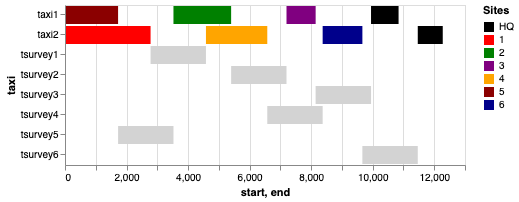

In [44]:

alt.renderers.enable('notebook')

backHQ = alt.Chart(ress_df[(ress_df.state == "HQ") ]).mark_bar(color=color[0]).encode(x='start',x2='end',y='taxi')

goto = []
for i in range(n):
    goto.append(alt.Chart(ress_df[(ress_df['state'].str[-1] == str(i+1))]).mark_bar(color=color[i+1]).encode(
        x='start',
        x2='end',
        y='taxi',
        color=alt.Color('Sites', scale=alt.Scale(domain=list(data['name']) , range=color))
    ))
surveys = alt.Chart(survey2_df).mark_bar(color=color[len(color)-1]).encode(x='start',x2='end',y='taxi')

graph_all = backHQ

for i in range(len(goto)):
    graph_all = graph_all + goto[i]
graph_all + surveys




## References
Ikonen, T. J., & Harjunkoski, I. (2019). Incorporation of parameter prediction models of different fidelity into job shop scheduling. IFAC-PapersOnLine, 52(1), 142-147. doi:10.1016/j.ifacol.2019.06.051